In [24]:
#from google.colab import drive
#drive.mount('/content/drive')

In [51]:
#!pip install tensorflow
#!pip install pydotplus
#!pip install opencv-python 
#!pip install tensorflow_datasets

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/5.3 MB 2.2 MB/s eta 0:00:03
   ----------- ---------------------------- 1.6/5.3 MB 2.7 MB/s eta 0:00:02
   ----------------- ---------------------- 2.4/5.3 MB 2.9 MB/s eta 0:00:02
   ------------------- -------------------- 2.6/5.3 MB 2.8 MB/s eta 0:00:01
   --------------------- ------------------ 2.9/5.3 MB 2.4 MB/s eta 0:00:02
   ----------------------- ---------------- 3.1/5.3 MB 2.3 MB/s eta 0:00:01
   --------------------------- ------------ 3.7/5.3 MB 2.2 MB/s eta 0:00:01
   ------------------------------- -------- 4.2/5.3 MB 2.2 MB/s eta 0:00:01
   -----------

In [1]:
import os
import pandas as pd
import numpy as np
import glob
from skimage import io
import skimage.transform as trans
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
#from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping,TensorBoard,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pydotplus
import time
start =time.process_time()
import cv2
from PIL import Image
import seaborn as sns
import tensorflow_datasets as tfds
import random


________________________________________________
## Analysis of Dataset
________________________________________________

In [3]:
train_directory = 'Group_Project_Data_2/Train/'
valid_directory ='Group_Project_Data_2/Valid/'
batch_size = 32

In [7]:
def Data_details(train_directory, valid_directory):
    classifications = []
    image_classification = [] 
    train_numbers = []
    valid_numbers = []
    n_test = []
    height = []
    width = []
    
    for i in os.listdir(valid_directory): # Fake (First iteration) and Real(Second iteration)
        classifications.append(i)
        training_images = os.listdir(train_directory  + i) # 'Group_Project_Data_2/Train/fake'
        validation_images = os.listdir(valid_directory + i) # 'Group_Project_Data_2/Train/fake'
        train_numbers.append(len(training_images))
        valid_numbers.append(len(validation_images))
        
        for j in training_images:
            image_classification.append(i)
            img = Image.open(train_directory + i + '/' + j) #  'Group_Project_Data_2/Train/fake/img_0'
            img_array = np.array(img)

            height.append(img_array.shape[0]) #28 x 28
            width.append(img_array.shape[1])
    return train_numbers, valid_numbers, classifications, image_classification, height, width

In [9]:
train_numbers, valid_numbers, categories,image_classification, height, width = Data_details(train_directory, valid_directory )

In [13]:
data_number_details = pd.DataFrame({'categories': categories, 'Number of Training images': train_numbers, 'Number of Validation images': valid_numbers})
data_number_details

,categories,Number of Training images,Number of Validation images
0,Fake,3000,1000
1,Real,3000,1000


Text(0.5, 1.0, 'Training Images by Category')

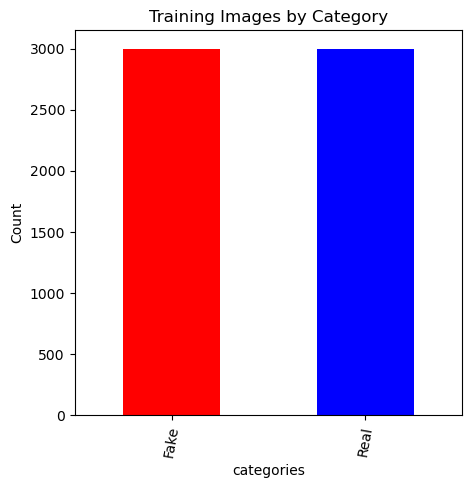

In [17]:
data_number_details.set_index('categories')['Number of Training images'].plot.bar(color=['r','b'], figsize=(5, 5))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

In [23]:
data_image_details = pd.DataFrame({'categories': image_classification, 'height': height, 'width': width })
data_image_details.head()

,categories,height,width
0,Fake,64,64
1,Fake,64,64
2,Fake,64,64
3,Fake,64,64
4,Fake,64,64


In [25]:
image_description = data_image_details.groupby('categories').describe()
image_description

height                                            width        \
             count  mean  std   min   25%   50%   75%   max   count  mean   
categories                                                                  
Fake        3000.0  64.0  0.0  64.0  64.0  64.0  64.0  64.0  3000.0  64.0   
Real        3000.0  64.0  0.0  64.0  64.0  64.0  64.0  64.0  3000.0  64.0   

                                               
            std   min   25%   50%   75%   max  
categories                                     
Fake        0.0  64.0  64.0  64.0  64.0  64.0  
Real        0.0  64.0  64.0  64.0  64.0  64.0

________________________________________________
## Defining a function to load the data
________________________________________________

In [118]:
def dataset(file_dir, features):
    featured = []
    labelled = []
    for feature in features:
        label = features.index(feature)
        file = os.path.join(file_dir, feature)
        for path in os.listdir(file):
            img = os.path.join(file, path)
            images = cv2.imread(img)
            images = cv2.resize(images, (64,64))
            #images = np.expand_dims(images, axis=0) - this added an extra dimension which caused issues during training
            featured.append(images)
            labelled.append(label)
    print("Done!!!")
    return featured, labelled
        

## Load Training Dataset

In [120]:
features  = ["Fake", "Real"]

In [122]:
file_dir = 'Group_Project_Data_2/Train'

In [124]:
feature, label = dataset(file_dir, features)

Done!!!


In [126]:
feature = np.array(feature) #why? it's already in array form
label = np.array(label)
print(feature.shape), print(label.shape)

(6000, 64, 64, 3)
(6000,)


(None, None)

________________________________________________
## Display Images
________________________________________________

In [54]:
batch_size = 32
image_size = 64

In [56]:
def load_train(lib1, directory):
    data = lib1(rescale=1. / 255,
                                   rotation_range=0,
                                   fill_mode='nearest',
                                   shear_range=0,
                                   zoom_range=0,
                                   brightness_range=(0.5, 1.5),
                                   width_shift_range=0,
                                   height_shift_range=0,
                                   horizontal_flip=False)
    train_dataset = data.flow_from_directory(directory,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  class_mode='sparse')
    return  train_dataset

In [58]:
#directory =  '/content/drive/MyDrive/PrinceAssignment/Assignment_prince/Group_Project_Data_2/Train'
directory =  'Group_Project_Data_2/Train'
lib1 = ImageDataGenerator
Training_data = load_train(lib1, directory)

Found 6000 images belonging to 2 classes.


Found 6000 files belonging to 2 classes.
Using 4800 files for training.


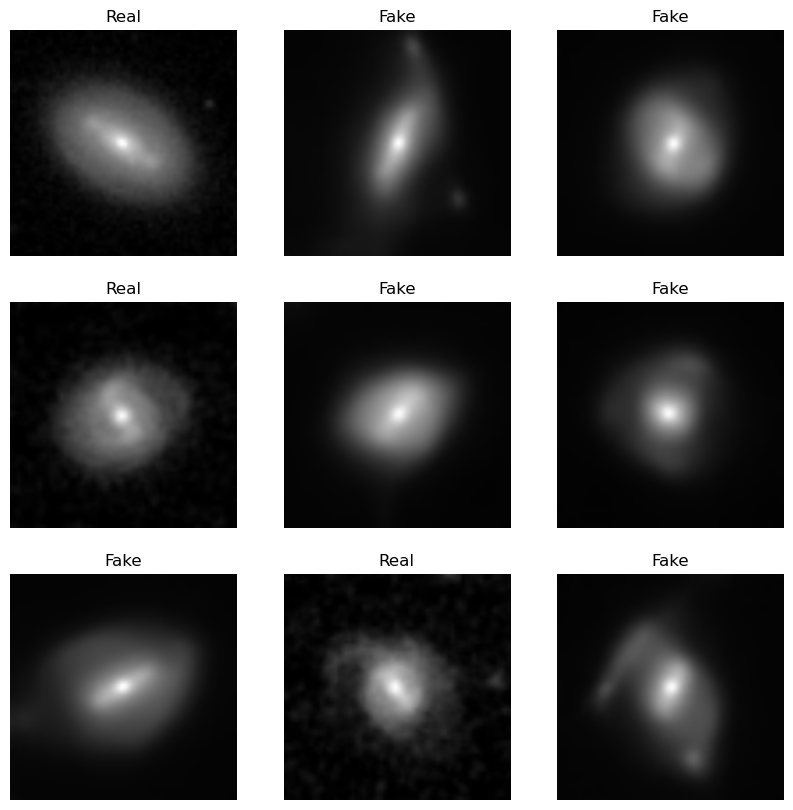

In [60]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Group_Project_Data_2/Train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224,224),
  batch_size=batch_size)

class_names = train_ds.class_names


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Histogram Equalization Function

In [64]:
def dataset(file_directory, features, save_dir1, save_dir2):
    for feature in features:
        file = os.path.join(file_dir, feature)
        n = 0
        m = 0
        for path in os.listdir(file):
            img = os.path.join(file, path)
            img = cv2.imread(img,0)
            equ = cv2.equalizeHist(img)
            if feature == "Fake":
                cv2.imwrite(save_dir1.format(n),equ)
                n+=1
            else:
                cv2.imwrite(save_dir2.format(m),equ)
                m+=1               
    print("Done!!!")

## Data processing using Histogram Equalization

In [66]:
features  = ["Fake", "Real"]
file_dir = 'Group_Project_Data_2/Valid'
save_dir1 = 'Group_Project_Data_2/Validation/Fake/img_{}.png'
save_dir2 = 'Group_Project_Data_2/Validation/Real/img_{}.png'
dataset(file_dir, features, save_dir1,save_dir2)

Done!!!


Found 6000 files belonging to 2 classes.
Using 4800 files for training.


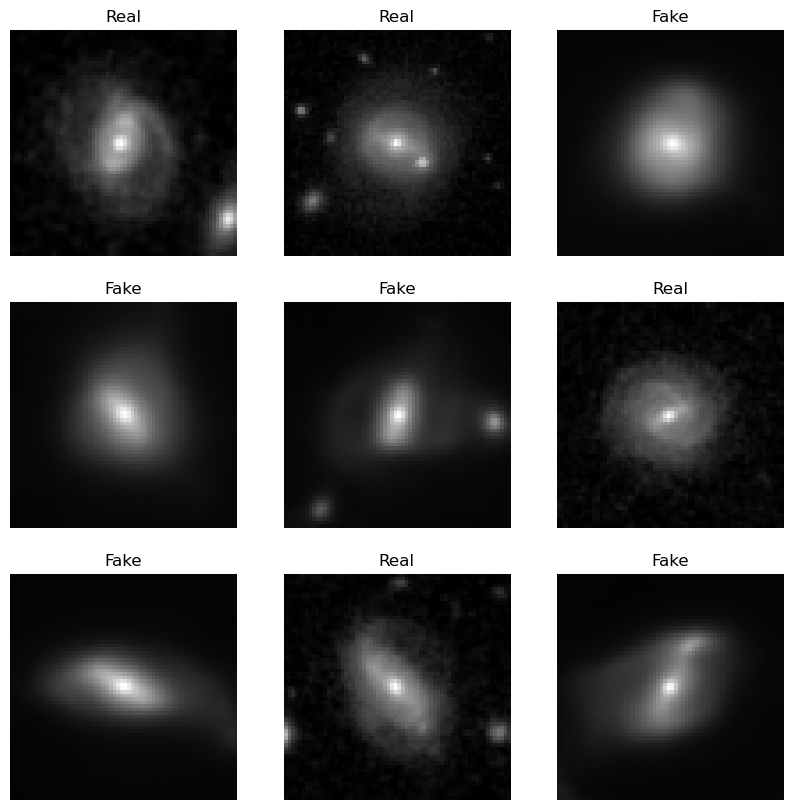

In [76]:
Training_data1 = tf.keras.utils.image_dataset_from_directory(
    'Group_Project_Data_2/Train', 
    subset = "training",
    validation_split = 0.2,
    seed = 23,
    image_size = (64,64),
    batch_size = 32)

class_names = Training_data1.class_names


def Display_images(dataset, plot, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            
Display_images(Training_data1, plt, class_names)

## Image Histogram (Pixel distribution)

In [78]:
def pixel_distribution(directory, directory1):
    plt.figure(figsize=(10,5))
    bins_num = 256
    for i,j in enumerate(os.listdir(directory)):
        img = os.path.join(directory,j)
        img = cv2.imread(img,0)
        hist, bin_edges = np.histogram(img, bins=bins_num)
        plt.title("REAL")
        plt.subplot(2,4,i+1)
        plt.hist(img.ravel(),256,[0,256])
        if i == 3:
            break
    plt.title("REAL")
    plt.show()
    
    plt.figure(figsize=(10,5))
    for i,j in enumerate(os.listdir(directory1)):
        img = os.path.join(directory,j)
        img = cv2.imread(img,0)
        hist, bin_edges = np.histogram(img, bins=bins_num)
        plt.subplot(2,4,i+1)
        plt.title("FAKE")
        plt.hist(img.ravel(),256,[0,256])
        if i == 3:
            break
    plt.show()
   

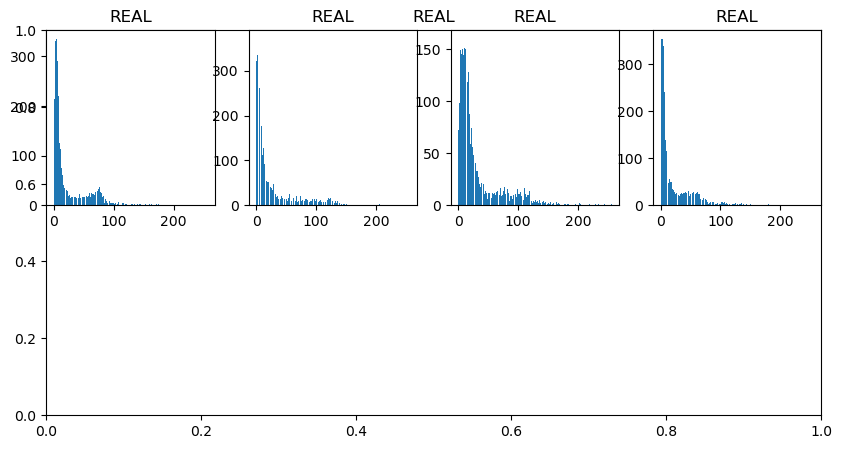

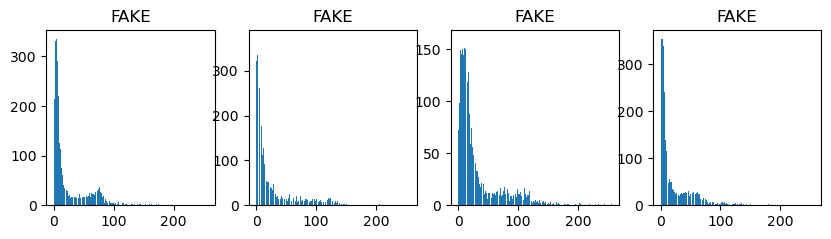

In [80]:
directory = 'Group_Project_Data_2/Train/Real'
directory1 = 'Group_Project_Data_2/Train/Fake'
pixel_distribution(directory, directory1)

________________________________________________
## Split dataset into Training and Validation set
________________________________________________

In [128]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size = 0.20, shuffle = True, random_state = 10)

## Model Development

In [130]:
def models():
    inputs_data = tf.keras.Input(shape = (64,64,3))
    x = layers.Conv2D(64, 3)(inputs_data)
    x = tf.keras.activations.relu(x)
    x = layers.Conv2D(64, 3)(x)
    x = tf.keras.activations.relu(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x) #used MaxPool2D instead of 3D becuase data is images not videos
    x = layers.Conv2D(128, 3)(x)
    x = tf.keras.activations.relu(x)
    x = layers.Conv2D(128, 3)(x)
    x = tf.keras.activations.relu(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(256, 3)(x)
    x = tf.keras.activations.relu(x)
    x = layers.Conv2D(256,3)(x)
    x = tf.keras.activations.relu(x)
    x = layers.Conv2D(256,3)(x)
    x = tf.keras.activations.relu(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(512, 3)(x)
    x = tf.keras.activations.relu(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4056)(x)
    x = layers.Dense(4056)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2)(x)
    model = tf.keras.Model(inputs = inputs_data, outputs = outputs)
    return model


In [132]:
model = models()

In [134]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 26, 26, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 9, 9, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 1, 1, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,461,474 (81.87 MB)

 Trainable params: 21,460,578 (81.87 MB)

 Non-trainable params: 896 (3.50 KB)

None


In [136]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
          metrics=['accuracy'])

In [138]:
learning_rate_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.7, patience=3, verbose=1, min_delta=1e-4, mode='min')
model_checkpoint = ModelCheckpoint('real_fake.weights.h5', monitor='loss',verbose=1, save_best_only=True,save_weights_only=True)
model_EarlyStopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=7, verbose=0, mode='auto')

In [140]:
galaxies = model.fit(x_train, y_train,
                   batch_size=64, 
                   epochs=1, validation_data =(x_test, y_test),
                   verbose=1, 
                   callbacks=[model_checkpoint, learning_rate_reduce,model_EarlyStopping])


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9019 - loss: 0.8943
Epoch 1: loss improved from inf to 0.30337, saving model to real_fake.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9027 - loss: 0.8865 - val_accuracy: 0.6642 - val_loss: 0.5572 - learning_rate: 3.0000e-04


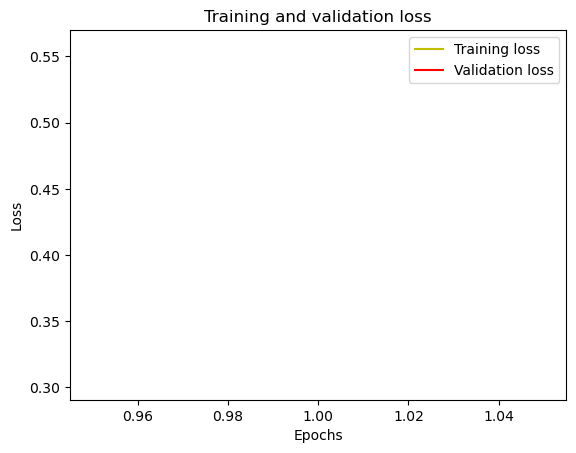

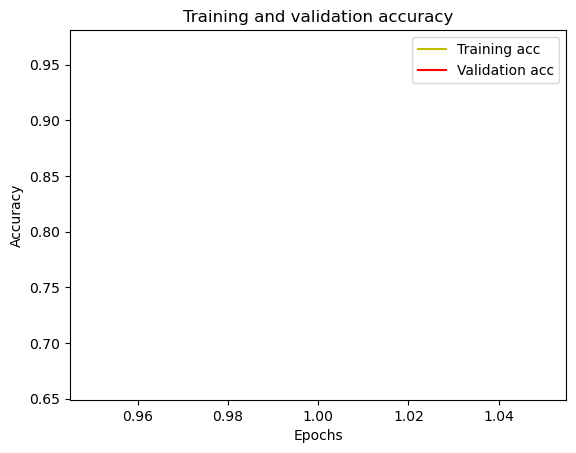

In [142]:
loss =galaxies.history['loss']
val_loss = galaxies.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


accuracy = galaxies.history['accuracy']
val_accuracy = galaxies.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [144]:
model.evaluate(x_test, y_test, batch_size=64, verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.6788 - loss: 0.5210


[0.5571953058242798, 0.6641666889190674]

# Model Evaluation

## Loading of model architecture and weight

In [148]:
model.save('real_fake.h5')
model = models()
model.load_weights('real_fake.h5')

## Loading Validation dataset

In [150]:
file_dir1 = 'Group_Project_Data_2/Valid'

In [152]:
feature1, label1 = dataset(file_dir1, features)

Done!!!


In [154]:
feature1 = np.array(feature1)
label1 = np.array(label1)
print(feature1.shape), print(label1.shape)

(2000, 64, 64, 3)
(2000,)


(None, None)

In [156]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

## Saving a copy of original dataset before shuffling

In [158]:
feature1_copy = feature1.copy()

## Data Shuffling

In [160]:
feature1,label1  = shuffle(feature1, label1 , random_state=0)

## Reshaping and One hot Encoding the label

In [164]:
reshaped_label = label1.reshape(len(label1), 1)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_test_encoded = onehot_encoder.fit_transform(reshaped_label)

## Model prediction

In [166]:
y_prediction = model.predict(feature1)

y_pred = np.argmax(y_prediction, axis=1)

y_test= np.argmax(y_test_encoded, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step


## Plotting Confussion matrix

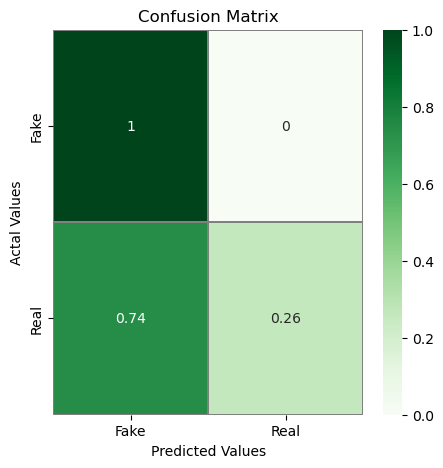

In [168]:

cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,index = ['Fake','Real'], columns = ['Fake','Real'])

plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True,linewidths=0.01,cmap="Greens", linecolor="gray")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Plotting Conffussion report

In [170]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73      1000
           1       1.00      0.26      0.41      1000

    accuracy                           0.63      2000
   macro avg       0.79      0.63      0.57      2000
weighted avg       0.79      0.63      0.57      2000



## Plotting ROC Curve

In [172]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from itertools import cycle

In [174]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_encoded.ravel(), y_prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_encoded.ravel(), y_prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [176]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

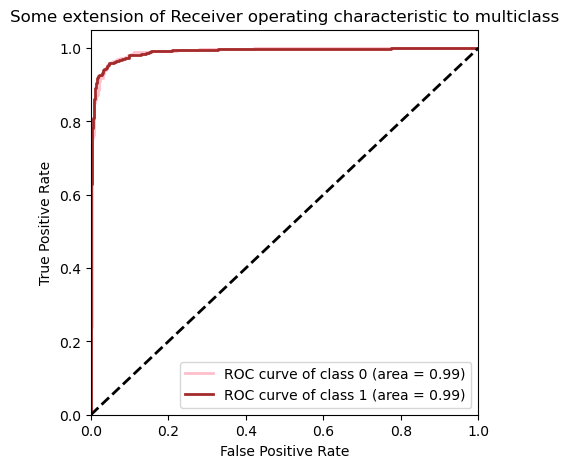

In [178]:
plt.figure(figsize=(5,5))
lw = 2


colors = cycle(["pink", "brown", ])

for i, color in zip(range(2), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Saving validation image name into CSV file

In [180]:
IMG_DIR = 'Group_Project_Data_2/Valid/Fake'
IMG_DIR1 = 'Group_Project_Data_2/Valid/Real'

In [182]:
images = os.listdir(IMG_DIR)
images1 = os.listdir(IMG_DIR1)
with open("train.csv", "w") as f:
    f.write("\n".join(images) + "\n")
    f.write("\n".join(images1) + "\n")

## Creating Class and Predicted column for the CSV File

In [184]:
cols = ['Name', 'Class','PredictedClass']

In [186]:
data = pd.read_csv("train.csv", names = cols)
data.head()

,Name,Class,PredictedClass
0,img_0.png,NaN,NaN
1,img_1.png,NaN,NaN
2,img_10.png,NaN,NaN
3,img_100.png,NaN,NaN
4,img_101.png,NaN,NaN


## Shuffling the image name to align with the earlier shuffled label

In [188]:
name = []
for i in data['Name']:
    name.append(i)

In [190]:
feature, name  = shuffle(feature1_copy, name, random_state=0)

## Assigning values to dataframe file

In [192]:
data['Name'] = name
data['Class'] = y_test 
data['PredictedClass'] = y_pred

## Image, Original class and predicted class.

In [194]:
data

,Name,Class,PredictedClass
0,img_463.png,0,0
1,img_27.png,1,1
2,img_217.png,1,0
3,img_757.png,0,0
4,img_778.png,1,0
...,...,...,...
1995,img_850.png,0,0
1996,img_293.png,1,1
1997,img_687.png,1,0
1998,img_601.png,0,0


## Ascertain the pridicted class and Original class

In [212]:
def ascertain(csv_file, a, b, c):
    n = 1
    for i in csv_file[a]:
        if csv_file[a].iloc[i] != csv_file[b].iloc[i]:
            print("This image was predicted wrongly:",csv_file[c][i])
            n = 0
        else:
            continue
    if n == 1:
        print("Predicted Class is 100% correct")
    

In [214]:
csv_file = data
a = "Class" 
b = "PredictedClass"
c = "Name"

In [216]:
ascertain(csv_file, a, b, c)

Predicted Class is 100% correct
